In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os,sys
os.chdir('C:/Users/arpit.goel/Documents/Projects/Kaggle/27_MCK_Health')

In [14]:
df_train=pd.read_csv('01.RawData/train_ajEneEa.csv')
df_test=pd.read_csv('01.RawData/test_v2akXPA.csv')
df_subm=pd.read_csv('01.RawData/sample_submission_1.csv')

In [25]:
def get_signals(df1):
    df=df1.copy()
    df['sig_gender_m']=(df['gender']=='Male').astype(np.int8)
    df['sig_gender_f']=(df['gender']=='Female').astype(np.int8)
    df['sig_gender_o']=(df['gender']=='Other').astype(np.int8)
    df['sig_age']=df['age']
    df['sig_hypertension']=df['hypertension']
    df['sig_heart_disease']=df['heart_disease']
    df['sig_married']=(df['ever_married']=='Yes').astype(np.int8)
    df['sig_work1']=(df['work_type']=='Private').astype(np.int8)
    df['sig_work2']=(df['work_type']=='Self-employed').astype(np.int8)
    df['sig_work3']=(df['work_type']=='children').astype(np.int8)
    df['sig_work4']=(df['work_type']=='Govt_job').astype(np.int8)
    df['sig_work5']=(df['work_type']=='Never_worked').astype(np.int8)
    df['sig_residence']=(df['Residence_type']=='Urban').astype(np.int8)
    df['sig_glucose_level']=df['avg_glucose_level']
    df['sig_bmi1']=df['bmi'].fillna(-9999)
    df['sig_bmi2']=df['bmi'].isnull().astype(np.int8)
    df['sig_smoke1']=df['smoking_status'].isin(['never smoked']).astype(np.int8)
    df['sig_smoke2']=df['smoking_status'].isin(['formerly smoked']).astype(np.int8)
    df['sig_smoke3']=df['smoking_status'].isin(['smokes']).astype(np.int8)
    df['sig_smoke4']=df['smoking_status'].isnull().astype(np.int8)

    output_sigs=[x for x in df.columns if x[:3] in ['sig','str']]
    return df[output_sigs]

sigs_train=get_signals(df_train)
sigs_test=get_signals(df_test)

In [40]:
sigs_train['sample']=np.random.random(len(sigs_train))<0.8
idv=[x for x in sigs_train.columns if x[:3] in ['sig']]
X_ins=sigs_train[sigs_train['sample']==1][idv]
X_oos=sigs_train[sigs_train['sample']==0][idv]
Y_ins=sigs_train[sigs_train['sample']==1]['stroke']
Y_oos=sigs_train[sigs_train['sample']==0]['stroke']

In [41]:
X_ins.shape,X_oos.shape,Y_ins.shape,Y_oos.shape

((34780, 20), (8620, 20), (34780L,), (8620L,))

In [59]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

def modelfit(alg, useTrainCV=True, cv_folds=5, early_stopping_rounds=20):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_ins.values, label=Y_ins.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_ins.values, Y_ins.values,eval_metric='auc')
        
    #Predict training set:
    dtrain_predprob = alg.predict_proba(X_ins.values)[:,1]
    dvalid_predprob = alg.predict_proba(X_oos.values)[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "AUC Score (Train): %f" % metrics.roc_auc_score(Y_ins, dtrain_predprob)
    print "AUC Score (Valid): %f" % metrics.roc_auc_score(Y_oos, dvalid_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
AUC Score (Train): 0.880954
AUC Score (Valid): 0.840172


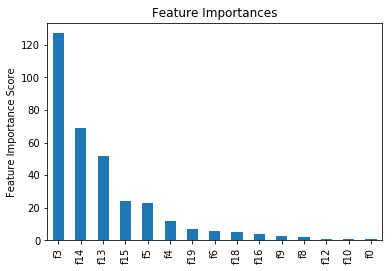

In [93]:
#Choose all predictors except target & IDcols
xgb1 = XGBClassifier(
 learning_rate=0.1,
 n_estimators=50,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1)

In [94]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=50, max_depth=3,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=1, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_ins,Y_ins)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.86677, std: 0.01219, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.86667, std: 0.01189, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.86634, std: 0.01191, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.86437, std: 0.01164, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.86584, std: 0.01179, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.86620, std: 0.01183, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.85955, std: 0.01301, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.85993, std: 0.01145, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.86291, std: 0.01106, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.85291, std: 0.01193, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.85658, std: 0.01230, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.86000, std: 0.01091, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 1

In [95]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=50, max_depth=3,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_ins,Y_ins)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.86677, std: 0.01219, params: {'gamma': 0.0},
  mean: 0.86670, std: 0.01195, params: {'gamma': 0.1},
  mean: 0.86664, std: 0.01211, params: {'gamma': 0.2},
  mean: 0.86664, std: 0.01211, params: {'gamma': 0.3},
  mean: 0.86655, std: 0.01205, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.8667693801125912)


Model Report
AUC Score (Train): 0.880954
AUC Score (Valid): 0.840172


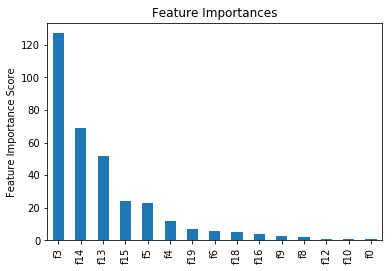

In [98]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=50,
 max_depth=3,
 min_child_weight=1,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2)

In [99]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=50, max_depth=3,
 min_child_weight=1, gamma=0.0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_ins,Y_ins)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.86694, std: 0.01315, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.86700, std: 0.01287, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.86700, std: 0.01301, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.86693, std: 0.01312, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.86785, std: 0.01230, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.86720, std: 0.01330, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.86732, std: 0.01270, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.86655, std: 0.01242, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.86669, std: 0.01247, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.86670, std: 0.01174, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.86677, std: 0.01219, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.86580, std: 0.01117, params: {'subsample': 0.9, 'colsample_bytree'

In [102]:
param_test5 = {
 'colsample_bytree':[i/100.0 for i in range(40,60,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=50, max_depth=3,
 min_child_weight=1, gamma=0.0, subsample=0.7, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_ins,Y_ins)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.86730, std: 0.01435, params: {'colsample_bytree': 0.4},
  mean: 0.86772, std: 0.01449, params: {'colsample_bytree': 0.45},
  mean: 0.86769, std: 0.01378, params: {'colsample_bytree': 0.5},
  mean: 0.86772, std: 0.01367, params: {'colsample_bytree': 0.55}],
 {'colsample_bytree': 0.45},
 0.8677209835068996)

In [103]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=50, max_depth=3,
 min_child_weight=1, gamma=0.0, subsample=0.7, colsample_bytree=0.45,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_ins,Y_ins)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.86772, std: 0.01449, params: {'reg_alpha': 1e-05},
  mean: 0.86773, std: 0.01447, params: {'reg_alpha': 0.01},
  mean: 0.86801, std: 0.01430, params: {'reg_alpha': 0.1},
  mean: 0.86771, std: 0.01493, params: {'reg_alpha': 1},
  mean: 0.85274, std: 0.02081, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.1},
 0.8680060759577302)


Model Report
AUC Score (Train): 0.879753
AUC Score (Valid): 0.841703


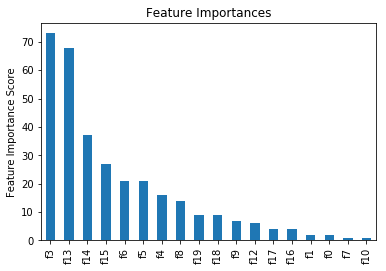

In [105]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=50,
 max_depth=3,
 min_child_weight=1,
 gamma=0.0,
 subsample=0.7,
 colsample_bytree=0.45,
 reg_alpha=0.1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3)

In [107]:
df_test['stroke']= xgb3.predict_proba(X_oos.values)[:,1]


ValueError: Length of values does not match length of index

In [109]:
xgb = XGBClassifier( learning_rate =0.1, n_estimators=50, max_depth=3, min_child_weight=1, gamma=0.0, subsample=0.7,
 colsample_bytree=0.45, reg_alpha=0.1, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
xgb.fit(X_ins.values, Y_ins.values,eval_metric='auc')


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.45,
       gamma=0.0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=50, nthread=4,
       objective='binary:logistic', reg_alpha=0.1, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.7)

In [111]:
xgb.predict_proba(X_oos.values)[:,1]


array([ 0.02143048,  0.00649086,  0.0505951 , ...,  0.00623278,
        0.01269023,  0.05702925], dtype=float32)

In [112]:
df_test.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,36306,Male,80.0,0,0,Yes,Private,Urban,83.84,21.1,formerly smoked
1,61829,Female,74.0,0,1,Yes,Self-employed,Rural,179.50,26.0,formerly smoked
2,14152,Female,14.0,0,0,No,children,Rural,95.16,21.2,NaN
3,12997,Male,28.0,0,0,No,Private,Urban,94.76,23.4,NaN
4,40801,Female,63.0,0,0,Yes,Govt_job,Rural,83.57,27.6,never smoked


In [113]:
df_subm.head()

,id,stroke
0,36306,0
1,61829,0
2,14152,0
3,12997,0
4,40801,0


In [1]:
import os,sys
os.chdir('C:/Users/arpit.goel/Documents/Projects/Kaggle/27_MCK_Health')
%run 00.Scripts/01.XGBFirstVersion.py

In [26]:
feat_imp=pd.Series(xgb.booster().get_fscore()).sort_values(ascending=False)
feat_imp.cumsum()
idv=feat_imp[feat_imp.cumsum()/feat_imp.sum()<0.9].index.tolist()

['sig_avg_glucose_level',
 'sig_age',
 'sig_bmi',
 'sig_hypertension',
 'sig_bmi_missing',
 'sig_heart_disease',
 'sig_married',
 'sig_work_Self-employed']

In [11]:
pd.get_dummies(df_train['smoking_status']).add_prefix('sig_smoke_')

,sig_smoke_formerly smoked,sig_smoke_never smoked,sig_smoke_smokes
0,0,0,0
1,0,1,0
2,0,0,0
3,1,0,0
4,0,0,0
5,0,0,0
6,1,0,0
7,0,1,0
8,0,0,1
9,0,1,0
